In [1]:
from torch import nn
from torch.nn import functional
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import gym
from collections import deque
import random
import numpy as np

In [2]:
# class TileCoder_Carpole:
#     def __init__(self, num_tiles_per_dim, num_tilings, state_limits, clip_limits=None):
#         self.num_tiles_per_dim = num_tiles_per_dim
#         self.num_tilings = num_tilings
#         self.state_limits = np.array(state_limits)
#         self.clip_limits = np.array(clip_limits) if clip_limits is not None else state_limits
#         self.tile_widths = np.zeros(len(state_limits))
#         self.offsets = np.zeros(len(state_limits))
#         for i, (clip_limit, state_limit) in enumerate(zip(self.clip_limits, self.state_limits)):
#             # Use the clipped limit for calculating tile width, but keep the original limit for clipping states
#             self.tile_widths[i] = (clip_limit[1] - clip_limit[0]) / (num_tiles_per_dim - 2)
#             self.offsets[i] = self.tile_widths[i] / (2 * num_tilings)
#         self.total_tiles = num_tilings * num_tiles_per_dim * len(state_limits)

#     def get_tile_indices(self, state):
#         tile_indices = np.zeros(self.total_tiles)
#         for tiling in range(self.num_tilings):
#             for dim, (state_dim, limits, clip_limit, offset, tile_width) in enumerate(
#                 zip(state, self.state_limits, self.clip_limits, self.offsets, self.tile_widths)
#             ):
#                 clipped_state_dim = np.clip(state_dim, clip_limit[0], clip_limit[1])
#                 norm_state_dim = ((clipped_state_dim - clip_limit[0]) + (tiling * offset)) / tile_width
#                 # Calculate tile index for the dimension, with special handling for outermost tiles
#                 tile = int(norm_state_dim) + 1
#                 tile = max(1, min(self.num_tiles_per_dim - 2, tile))
#                 index = (tiling * self.num_tiles_per_dim * len(self.state_limits)) + (dim * self.num_tiles_per_dim) + tile
#                 tile_indices[index] = 1
#         return tile_indices

# num_tiles_per_dim = 100
# num_tilings = 5
# state_limits = [[-2.4, 2.4], [-np.inf, np.inf], [-12 * 2 * np.pi / 360, 12 * 2 * np.pi / 360], [-np.inf, np.inf]]
# clip_limits = [[-2.4, 2.4], [-10, 10], [-12 * 2 * np.pi / 360, 12 * 2 * np.pi / 360], [-10, 10]]

# # Initialize your tile coder here

# tile_coder = TileCoder_Carpole(num_tiles_per_dim=num_tiles_per_dim,
#                               num_tilings=num_tilings,
#                               state_limits=state_limits,
#                               clip_limits=clip_limits
#                               )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
class TileCoder_Mountain:
    def __init__(self, num_tiles_per_dim, num_tilings, state_limits):
        self.num_tiles_per_dim = num_tiles_per_dim
        self.num_tilings = num_tilings
        self.state_limits = np.array(state_limits)
        self.tile_widths = np.array([(limit[1] - limit[0]) / (num_tiles_per_dim - 1) for limit in state_limits])
        self.offsets = self.tile_widths / (2 * num_tilings)
        self.total_tiles = num_tilings * num_tiles_per_dim * len(state_limits)

    def get_tile_indices(self, state):
        tile_indices = np.zeros(self.total_tiles)
        for tiling in range(self.num_tilings):
            for dim, (state_dim, limits, offset, tile_width) in enumerate(
                zip(state, self.state_limits, self.offsets, self.tile_widths)
            ):
                norm_state_dim = ((state_dim - limits[0]) + (tiling * offset)) / tile_width
                tile = int(norm_state_dim) % self.num_tiles_per_dim
                if dim == 0:  # calculate position
                    index = (tiling * self.num_tiles_per_dim) + tile
                else:  # calculate velocity
                    index = (self.num_tilings * self.num_tiles_per_dim) + (tiling * self.num_tiles_per_dim) + tile
                tile_indices[index] = 1
        return tile_indices

# Define the environment name, number of features, number of actions, number of runs and episodes
env = gym.make('MountainCar-v0')
state_limits = [env.observation_space.low, env.observation_space.high]
num_tiles_per_dim = 20
num_tilings = 2
tile_coder = TileCoder_Mountain(num_tiles_per_dim, num_tilings, state_limits)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
import pickle

def save_rewards_data(rewards_data, filename='rewards_data.pkl'):
    """Save the rewards data to a pickle file."""
    with open(filename, 'wb') as file:
        pickle.dump(rewards_data, file)
    print(f'Rewards data saved to {filename}')


def load_rewards_data(filename='rewards_data.pkl'):
    """Load the rewards data from a pickle file."""
    try:
        with open(filename, 'rb') as file:
            rewards_data = pickle.load(file)
        print(f'Rewards data loaded from {filename}')
        return rewards_data
    except FileNotFoundError:
        print(f'Error: The file {filename} does not exist. Please check the file path and try again.')
        return None
    except Exception as e:
        print(f'An error occurred while loading the data: {e}')
        return None

In [5]:
import matplotlib.pyplot as plt

def plot_rewards(rewards_data, algorithm_name="Q learning"):
    """Plot the average performance and IQR of the policy."""
    plt.figure(figsize=(14, 7))

    for epsilon, alphas in rewards_data.items():
        for alpha, data in alphas.items():
            # Calculate average and IQR across runs for each episode
            data = np.array(data)  # Convert to numpy array for easier slicing
            avg_rewards = np.mean(data, axis=0)
            lower_quartile = np.percentile(data, 25, axis=0)
            upper_quartile = np.percentile(data, 75, axis=0)

            episodes = np.arange(len(avg_rewards)) + 1
            plt.plot(episodes, avg_rewards, label=f'ε={epsilon}, α={alpha}')
            plt.fill_between(episodes, lower_quartile, upper_quartile, alpha=0.25)

    plt.title(f'Average Performance and IQR by Epsilon and Alpha ({algorithm_name})')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.show()

In [6]:
# class RBFDiscritizer:
#     def __init__(self, num_rbf_per_state, state_bounds, num_states):
#         self.num_rbf_per_state = num_rbf_per_state
#         self.state_bounds = state_bounds
#         self.num_states = num_states
#         self.num_rbf = num_rbf_per_state * np.ones(self.num_states).astype(int)
#         self.num_ind = np.prod(self.num_rbf)
#         self.width = 1. / (self.num_rbf - 1.)
#         self.rbf_sigma = self.width[0] / 2.
#         self.rbf_den = 2 * self.rbf_sigma ** 2
#         self.centres = self.build_centers()

#     def build_centers(self):
#         # Generate a meshgrid for the centers based on the number of RBFs per dimension
#         ranges = [np.linspace(0, 1, num) for num in self.num_rbf]
#         mesh = np.meshgrid(*ranges, indexing='ij')
#         # Flatten the meshgrid and stack it to get the center coordinates
#         center_coords = np.stack([axis.flatten() for axis in mesh], axis=-1)
#         return center_coords

#     def normalize_state(self, state):
#         normalized = np.zeros(len(state))
#         for i, (lower, upper) in enumerate(self.state_bounds):
#             normalized[i] = (state[i] - lower) / (upper - lower)
#         return normalized

#     def encode(self, state):
#         normalized_state = self.normalize_state(state)
#         _phi = np.zeros(self.num_ind)
#         for _k in range(self.num_ind):
#             _phi[_k] = np.exp(-np.linalg.norm(normalized_state - self.centres[_k, :]) ** 2 / self.rbf_den)
#         return _phi

In [7]:
class Model(nn.Module):
    def __init__(self, input_features, output_values):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features=input_features, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=output_values)

    def forward(self, x):
        x = functional.selu(self.fc1(x))
        x = functional.selu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
# class DDQN:
#     def __init__(self, env, discretizer, use_cuda=True, learning_rate=1e-5, gamma=0.7, memory_len=10000, start_epsilon=1):
#         self.device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
#         self.env = env
#         self.discretizer = discretizer
#         self.learning_rate = learning_rate
#         self.gamma = gamma

#         self.epsilon = start_epsilon
#         self.min_epsilon = 0.1
#         self.epsilon_decay = 0.9 / 2.5e3
#         self.memory_len = memory_len
#         self.memory = deque(maxlen=self.memory_len)
#         self.criterion = nn.MSELoss()

#         input_features = discretizer.num_ind
#         output_values = env.action_space.n
#         self.policy_net = Model(input_features, output_values).to(self.device)
#         self.target_net = Model(input_features, output_values).to(self.device)

#         self.target_net.load_state_dict(self.policy_net.state_dict())
#         self.target_net.eval()

#     def get_states_tensor(self, sample, states_idx):
#         sample_len = len(sample)
#         states_tensor = torch.empty((sample_len, self.discretizer.num_ind), dtype=torch.float32, requires_grad=False)

#         for i, state in enumerate(sample):
#             num_array = state[states_idx]
#             states_tensor[i, :] = torch.from_numpy(num_array)

#         return states_tensor

#     def normalize_state(self, state):
#         state[0] /= 2.5
#         state[1] /= 2.5
#         state[2] /= 0.3
#         state[3] /= 0.3

#     def state_reward(self, state, env_reward):
#         return env_reward - (abs(state[0]) + abs(state[2])) / 2.5

#     def get_action(self, state, e=None):
#         if e is None:
#             e = self.epsilon
#         if random.random() < e:
#             return random.randrange(0, self.env.action_space.n)
#         else:
#             encoded_state = self.discretizer.encode(state)
#             encoded_state = torch.tensor(encoded_state, dtype=torch.float32, device=self.device)
#             return self.policy_net(encoded_state).argmax().item()

#     def fit(self, model, inputs, labels):
#         inputs = inputs.to(self.device)
#         labels = labels.to(self.device)
#         train_ds = TensorDataset(inputs, labels)
#         train_dl = DataLoader(train_ds, batch_size=5)

#         optimizer = torch.optim.Adam(params=model.parameters(), lr=self.learning_rate)
#         model.train()
#         total_loss = 0.0

#         for x, y in train_dl:
#             out = model(x)
#             loss = self.criterion(out, y)
#             total_loss += loss.item()
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         model.eval()
#         return total_loss / len(train_dl)

#     def optimize_model(self, train_batch_size=100):
#         if len(self.memory) < train_batch_size:
#             return
#         train_sample = random.sample(self.memory, train_batch_size)

#         state = self.get_states_tensor(train_sample, 0).to(self.device)
#         next_state = self.get_states_tensor(train_sample, 3).to(self.device)

#         q_estimates = self.policy_net(state).detach()
#         next_state_q_estimates = self.target_net(next_state).detach()
#         next_actions = self.policy_net(next_state).argmax(dim=1)

#         for i in range(len(train_sample)):
#             next_action = next_actions[i].item()
#             q_estimates[i][train_sample[i][1]] = (self.state_reward(next_state[i], train_sample[i][2]) +
#                                                   self.gamma * next_state_q_estimates[i][next_action].item())

#         self.fit(self.policy_net, state, q_estimates)

#     def train_one_episode(self):
#         current_state = self.env.reset()
#         self.normalize_state(current_state)
#         done = False
#         score = 0
#         reward = 0
#         while not done:
#             action = self.get_action(current_state, self.epsilon)
#             next_state, env_reward, done, _ = self.env.step(action)
#             self.normalize_state(next_state)
#             encoded_current_state = self.discretizer.encode(current_state)
#             encoded_next_state = self.discretizer.encode(next_state)
#             self.memory.append((encoded_current_state, action, env_reward, encoded_next_state))
#             current_state = next_state
#             score += env_reward
#             reward += self.state_reward(next_state, env_reward)

#             self.optimize_model(100)

#             self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay)

#         return score, reward

#     def test(self):
#         state = self.env.reset()
#         self.normalize_state(state)
#         done = False
#         score = 0
#         reward = 0
#         while not done:
#             action = self.get_action(state, 0)  # Using 0 to bypass random action selection
#             state, env_reward, done, _ = self.env.step(action)
#             self.normalize_state(state)
#             score += env_reward
#             reward += self.state_reward(state, env_reward)

#         return score, reward

In [9]:
# class DDQN:
#     def __init__(self, env, tile_coder, use_cuda=True, learning_rate=1e-5, gamma=0.7, memory_len=10000, start_epsilon=1):
#         self.device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
#         self.env = env
#         self.tile_coder = tile_coder
#         self.learning_rate = learning_rate
#         self.gamma = gamma

#         self.epsilon = start_epsilon
#         self.min_epsilon = 0.1
#         self.epsilon_decay = 0.9 / 2.5e3
#         self.memory_len = memory_len
#         self.memory = deque(maxlen=self.memory_len)
#         self.criterion = nn.MSELoss()

#         input_features = tile_coder.total_tiles
#         output_values = env.action_space.n
#         self.policy_net = Model(input_features, output_values).to(self.device)
#         self.target_net = Model(input_features, output_values).to(self.device)

#         self.target_net.load_state_dict(self.policy_net.state_dict())
#         self.target_net.eval()

#     def get_states_tensor(self, sample, states_idx):
#         sample_len = len(sample)
#         states_tensor = torch.empty((sample_len, self.tile_coder.total_tiles), dtype=torch.float32, requires_grad=False)

#         for i, state in enumerate(sample):
#             num_array = state[states_idx]
#             states_tensor[i, :] = torch.from_numpy(num_array)

#         return states_tensor

#     def state_reward(self, state, env_reward):
#         return env_reward - (abs(state[0]) + abs(state[2])) / 2.5

#     def get_action(self, state, e=None):
#         if e is None:
#             e = self.epsilon
#         if random.random() < e:
#             return random.randrange(0, self.env.action_space.n)
#         else:
#             encoded_state = self.tile_coder.get_tile_indices(state)
#             encoded_state = torch.tensor(encoded_state, dtype=torch.float32, device=self.device)
#             return self.policy_net(encoded_state).argmax().item()

#     def fit(self, model, inputs, labels):
#         inputs = inputs.to(self.device)
#         labels = labels.to(self.device)
#         train_ds = TensorDataset(inputs, labels)
#         train_dl = DataLoader(train_ds, batch_size=5)

#         optimizer = torch.optim.Adam(params=model.parameters(), lr=self.learning_rate)
#         model.train()
#         total_loss = 0.0

#         for x, y in train_dl:
#             out = model(x)
#             loss = self.criterion(out, y)
#             total_loss += loss.item()
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         model.eval()
#         return total_loss / len(train_dl)

#     def optimize_model(self, train_batch_size=100):
#         if len(self.memory) < train_batch_size:
#             return
#         train_sample = random.sample(self.memory, train_batch_size)

#         state = self.get_states_tensor(train_sample, 0).to(self.device)
#         next_state = self.get_states_tensor(train_sample, 3).to(self.device)

#         q_estimates = self.policy_net(state).detach()
#         next_state_q_estimates = self.target_net(next_state).detach()
#         next_actions = self.policy_net(next_state).argmax(dim=1)

#         for i in range(len(train_sample)):
#             next_action = next_actions[i].item()
#             q_estimates[i][train_sample[i][1]] = (self.state_reward(next_state[i], train_sample[i][2]) +
#                                                   self.gamma * next_state_q_estimates[i][next_action].item())

#         self.fit(self.policy_net, state, q_estimates)

#     def train_one_episode(self):
#         current_state = self.env.reset()
#         done = False
#         score = 0
#         reward = 0
#         while not done:
#             action = self.get_action(current_state, self.epsilon)
#             next_state, env_reward, done, _ = self.env.step(action)
#             encoded_current_state = self.tile_coder.get_tile_indices(current_state)
#             encoded_next_state = self.tile_coder.get_tile_indices(next_state)
#             self.memory.append((encoded_current_state, action, env_reward, encoded_next_state))
#             current_state = next_state
#             score += env_reward
#             reward += self.state_reward(next_state, env_reward)

#             self.optimize_model(100)

#             self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay)

#         return score, reward

#     def test(self):
#         state = self.env.reset()
#         done = False
#         score = 0
#         reward = 0
#         while not done:
#             action = self.get_action(state, 0)  # Using 0 to bypass random action selection
#             state, env_reward, done, _ = self.env.step(action)
#             score += env_reward
#             reward += self.state_reward(state, env_reward)

#         return score, reward


In [10]:
class DDQN:
    def __init__(self, env, tile_coder, use_cuda=True, learning_rate=1e-5, gamma=0.7, memory_len=10000, start_epsilon=1):
        self.device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
        self.env = env
        self.tile_coder = tile_coder
        self.learning_rate = learning_rate
        self.gamma = gamma

        self.epsilon = start_epsilon
        self.min_epsilon = 0.1
        self.epsilon_decay = 0.9 / 2.5e3
        self.memory_len = memory_len
        self.memory = deque(maxlen=self.memory_len)
        self.criterion = nn.MSELoss()

        input_features = tile_coder.total_tiles
        output_values = env.action_space.n
        self.policy_net = Model(input_features, output_values).to(self.device)
        self.target_net = Model(input_features, output_values).to(self.device)

        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

    def get_states_tensor(self, sample, states_idx):
        sample_len = len(sample)
        states_tensor = torch.empty((sample_len, self.tile_coder.total_tiles), dtype=torch.float32, requires_grad=False)

        for i, state in enumerate(sample):
            num_array = state[states_idx]
            states_tensor[i, :] = torch.from_numpy(num_array)

        return states_tensor

    def state_reward(self, state, env_reward):
        return env_reward

    def get_action(self, state, e=None):
        if e is None:
            e = self.epsilon
        if random.random() < e:
            return random.randrange(0, self.env.action_space.n)
        else:
            encoded_state = self.tile_coder.get_tile_indices(state)
            encoded_state = torch.tensor(encoded_state, dtype=torch.float32, device=self.device)
            return self.policy_net(encoded_state).argmax().item()

    def fit(self, model, inputs, labels):
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)
        train_ds = TensorDataset(inputs, labels)
        train_dl = DataLoader(train_ds, batch_size=5)

        optimizer = torch.optim.Adam(params=model.parameters(), lr=self.learning_rate)
        model.train()
        total_loss = 0.0

        for x, y in train_dl:
            out = model(x)
            loss = self.criterion(out, y)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        return total_loss / len(train_dl)

    def optimize_model(self, train_batch_size=100):
        if len(self.memory) < train_batch_size:
            return
        train_sample = random.sample(self.memory, train_batch_size)

        state = self.get_states_tensor(train_sample, 0).to(self.device)
        next_state = self.get_states_tensor(train_sample, 3).to(self.device)

        q_estimates = self.policy_net(state).detach()
        next_state_q_estimates = self.target_net(next_state).detach()
        next_actions = self.policy_net(next_state).argmax(dim=1)

        for i in range(len(train_sample)):
            next_action = next_actions[i].item()
            q_estimates[i][train_sample[i][1]] = (self.state_reward(next_state[i], train_sample[i][2]) +
                                                  self.gamma * next_state_q_estimates[i][next_action].item())

        self.fit(self.policy_net, state, q_estimates)

    def train_one_episode(self):
        current_state = self.env.reset()
        done = False
        score = 0
        reward = 0
        while not done:
            action = self.get_action(current_state, self.epsilon)
            next_state, env_reward, done, _ = self.env.step(action)
            encoded_current_state = self.tile_coder.get_tile_indices(current_state)
            encoded_next_state = self.tile_coder.get_tile_indices(next_state)
            self.memory.append((encoded_current_state, action, env_reward, encoded_next_state))
            current_state = next_state
            score += env_reward
            reward += self.state_reward(next_state, env_reward)

            self.optimize_model(100)

            self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay)

        return score, reward

    def test(self):
        state = self.env.reset()
        done = False
        score = 0
        reward = 0
        while not done:
            action = self.get_action(state, 0)  # Using 0 to bypass random action selection
            state, env_reward, done, _ = self.env.step(action)
            score += env_reward
            reward += self.state_reward(state, env_reward)

        return score, reward


In [11]:
num_states = 4
num_rbf_per_state=4
state_bounds = [(-2.4, 2.4), (-10.0, 10.0), (-0.42, 0.42), (-10.0, 10.0)]

# discretizer = RBFDiscritizer(num_rbf_per_state=num_rbf_per_state, state_bounds=state_bounds, num_states=num_states)

# env = gym.make('CartPole-v1')

In [12]:
def main(used_alpha, used_epsilon, env, tile_coder, target_update_delay, test_delay, memory_len=10000, num_runs=1, num_episode=1000, save_file=""):


    # Initialize storage for reward data
    rewards_data = {epsilon: {alpha: [] for alpha in used_alpha} for epsilon in used_epsilon}

    for epsilon in used_epsilon:
        for alpha in used_alpha:
            print(f"Training with epsilon: {epsilon}, alpha: {alpha}")
            run_rewards = []  # Collect rewards for each run for the current config

            for run in range(num_runs):

                # avoid decay
                current_epsilon = epsilon

                print(f"Run {run + 1}/{num_runs}")

                # renew the wrapper class
                ddqn = DDQN(
                    env=env,
                    tile_coder=tile_coder,
                    use_cuda=True,
                    learning_rate=alpha,
                    gamma=0.99,
                    memory_len=memory_len,
                    start_epsilon=current_epsilon
                )

                best_test_reward = 0

                episode_rewards = []  # Collect rewards for each episode in the current run
                for i in range(num_episode):
                    score, reward = ddqn.train_one_episode()

                    print(f'Episode {i + 1}: score: {score} - reward: {reward}')

                    if i % target_update_delay == 0:
                        ddqn.target_net.load_state_dict(ddqn.policy_net.state_dict())
                        ddqn.target_net.eval()

                    if (i + 1) % test_delay == 0:
                        test_score, test_reward = ddqn.test()
                        print(f'Test Episode {i + 1}: test score: {test_score} - test reward: {test_reward}')
                        if test_reward > best_test_reward:
                            print('New best test reward. Saving model')
                            best_test_reward = test_reward
                            # torch.save(ddqn.policy_net.state_dict(), f'policy_net_{run}.pth')

                    # Add the rewards
                    episode_rewards.append(score)

                if num_episode % test_delay != 0:
                    test_score, test_reward = ddqn.test()
                    print(f'Test Episode {num_episode}: test score: {test_score} - test reward: {test_reward}')
                    if test_reward > best_test_reward:
                        print('New best test reward. Saving model')
                        best_test_reward = test_reward
                        # torch.save(ddqn.policy_net.state_dict(), f'policy_net_{run}.pth')

                # save the run rewards
                run_rewards.append(episode_rewards)

                print(f'best test reward: {best_test_reward}')

            # Store the rewards for the current epsilon and alpha configuration
            rewards_data[epsilon][alpha] = run_rewards

    if not(save_file == ""):
        save_rewards_data(rewards_data, save_file)

    return rewards_data

In [13]:
rewards_data = main(
    used_alpha=[1e-3,1e-4],
    used_epsilon=[0.1,0.9],  # start epsilon
    env=env,
    tile_coder=tile_coder,
    target_update_delay=5,
    test_delay=10,
    memory_len=10000,
    num_runs=1,
    num_episode=500,
    save_file="example_data.pkl"
)

Training with epsilon: 0.1, alpha: 0.001
Run 1/1


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: score: -200.0 - reward: -200.0
Episode 2: score: -200.0 - reward: -200.0
Episode 3: score: -200.0 - reward: -200.0
Episode 4: score: -200.0 - reward: -200.0
Episode 5: score: -200.0 - reward: -200.0
Episode 6: score: -200.0 - reward: -200.0
Episode 7: score: -200.0 - reward: -200.0
Episode 8: score: -200.0 - reward: -200.0
Episode 9: score: -200.0 - reward: -200.0
Episode 10: score: -200.0 - reward: -200.0
Test Episode 10: test score: -154.0 - test reward: -154.0
Episode 11: score: -200.0 - reward: -200.0
Episode 12: score: -200.0 - reward: -200.0
Episode 13: score: -200.0 - reward: -200.0
Episode 14: score: -200.0 - reward: -200.0
Episode 15: score: -200.0 - reward: -200.0
Episode 16: score: -200.0 - reward: -200.0
Episode 17: score: -200.0 - reward: -200.0
Episode 18: score: -200.0 - reward: -200.0
Episode 19: score: -200.0 - reward: -200.0
Episode 20: score: -200.0 - reward: -200.0
Test Episode 20: test score: -200.0 - test reward: -200.0
Episode 21: score: -200.0 - rewar

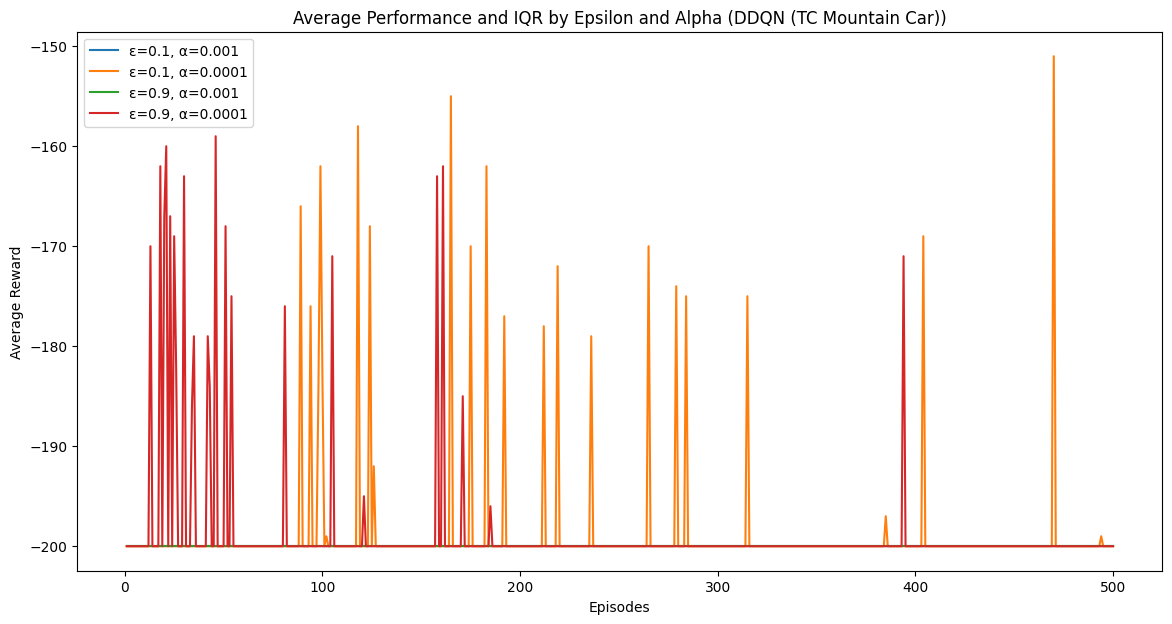

In [15]:
plot_rewards(rewards_data, algorithm_name="DDQN (TC Mountain Car)")